# Import Librairies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from race import Pilot
from blr import Prior, BLR
from matplotlib.ticker import FuncFormatter

# Color Palette Definition

In [2]:
red = sns.color_palette("blend:#ffffff,#ff1801", as_cmap=True)
reds = sns.color_palette(palette='Reds_r', n_colors=15)

# Utilities Functions

In [3]:
def milliseconds_to_time(milliseconds): # Convert 'millisecond' value to more readable format
    minutes, milliseconds = divmod(milliseconds, 60000)
    seconds, milliseconds = divmod(milliseconds, 1000)
    return f"{int(minutes)}:{int(seconds):02d}:{int(milliseconds):02d}"

def format_tick(value, tick_number): # Format tick on Plot
    return f"{milliseconds_to_time(value)}"

def participating(drivers, r_data, n_lap): # Create a list of all the drivers who will finish the race
    p = []
    for i in r_data['driverId'].unique().tolist():
        driver_data = r_data[r_data['driverId'] == i]
        if len(driver_data) == n_lap:
            p.append(drivers[drivers['driverId'] == i]['code'].tolist()[0])
    return p

def prob_position(sims, code): # Compute the position probability for a given pilot
    count = [0 for i in range(len(sims[0]))]
    for sim in sims:
        for pos in range(len(sims[0])):
            count[pos] += int(sim[pos] == code)
    return count

# Import Data

In [4]:
lap_times = pd.read_csv('data/lap_times.csv')
drivers = pd.read_csv('data/drivers.csv')
pit_stops = pd.read_csv('data/pit_stops.csv')

# Processing Data

## Select Race :

In [5]:
raceId = 1085 # France Grand Prix 2022
r_data = lap_times[lap_times['raceId'] == raceId].drop(columns=['raceId']).sort_values(by=['driverId', 'lap']).reset_index(drop=True).copy()
r_data['cum_milli'] = r_data['milliseconds'].groupby(r_data['driverId']).cumsum()
pt_data = pit_stops[pit_stops['raceId'] == raceId]

## Pre-Processing :

### Pace Indicator :

In [6]:
def slope_compute(df):
    slopes = [np.nan for i in range(4)]
    for i in range(4, len(df)):
        if df['driverId'].iloc[i] == df['driverId'].iloc[i - 4]:
            slopes.append((df['milliseconds'].iloc[i] - df['milliseconds'].iloc[i - 4]) / 4)
        else: 
            slopes.append(np.nan)
    return slopes

### Tire Age Calculation :

In [7]:
def tire_age(df, ref):
    age = [1]
    for i in range(1, len(df)):
        filtered = ref[(ref['driverId'] == df['driverId'].iloc[i]) & (ref['lap'] == df['lap'].iloc[i])]
        if df['driverId'].iloc[i] == df['driverId'].iloc[i - 1] and len(filtered) == 0:
            age.append(age[-1] + 1)
        else:
            age.append(1)
    return age

### Time Difference with Front Driver Calculation :

In [8]:
def delta_compute(df):
    delta = []
    for i in range(len(df)):
        if df['position'].iloc[i] != 1:
            over = df[(df['position'] == df['position'].iloc[i] - 1) & (df['lap'] == df['lap'].iloc[i])]
            delta.append(int(over['cum_milli']) - df['cum_milli'].iloc[i])
        else:
            delta.append(0)
    return delta

## Data Completion :

In [9]:
r_data['previous'] = r_data['milliseconds'].shift(1)
condition = r_data['lap'] == 1
r_data.loc[condition, ['previous']] = np.nan
r_data['slopes'], r_data['tire_age'], r_data['delta'] = slope_compute(r_data), tire_age(r_data, pt_data), delta_compute(r_data)

# EDA (Exploratory Data Analysis)

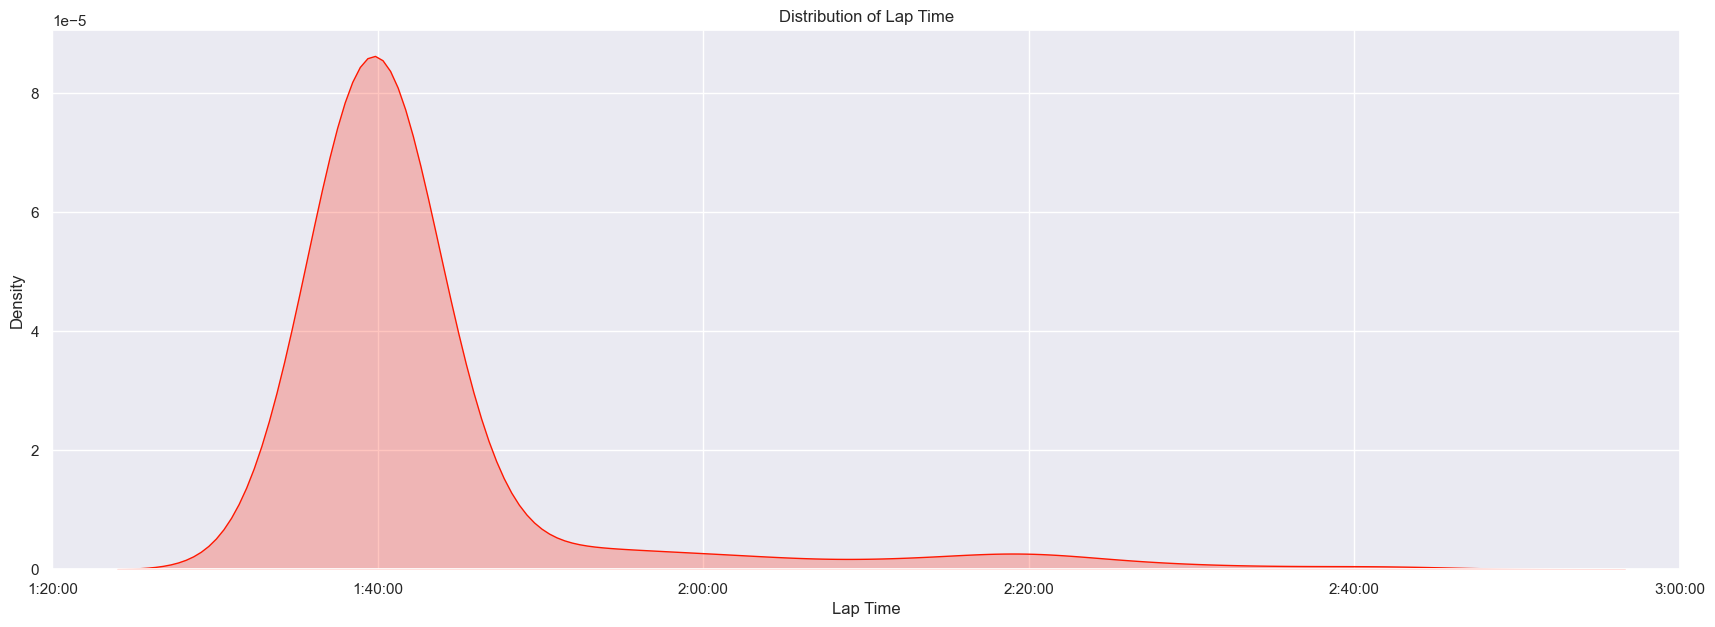

In [10]:
sns.set_theme()
sns.set(rc={'figure.figsize':(21,7)})
sns.kdeplot(data=r_data, x="milliseconds", bw_adjust=1.5, fill='True', color='#ff1801').set_title('Distribution of Lap Time')
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_tick))
plt.xlabel('Lap Time'), plt.xlim(80000, 180000)
plt.show()

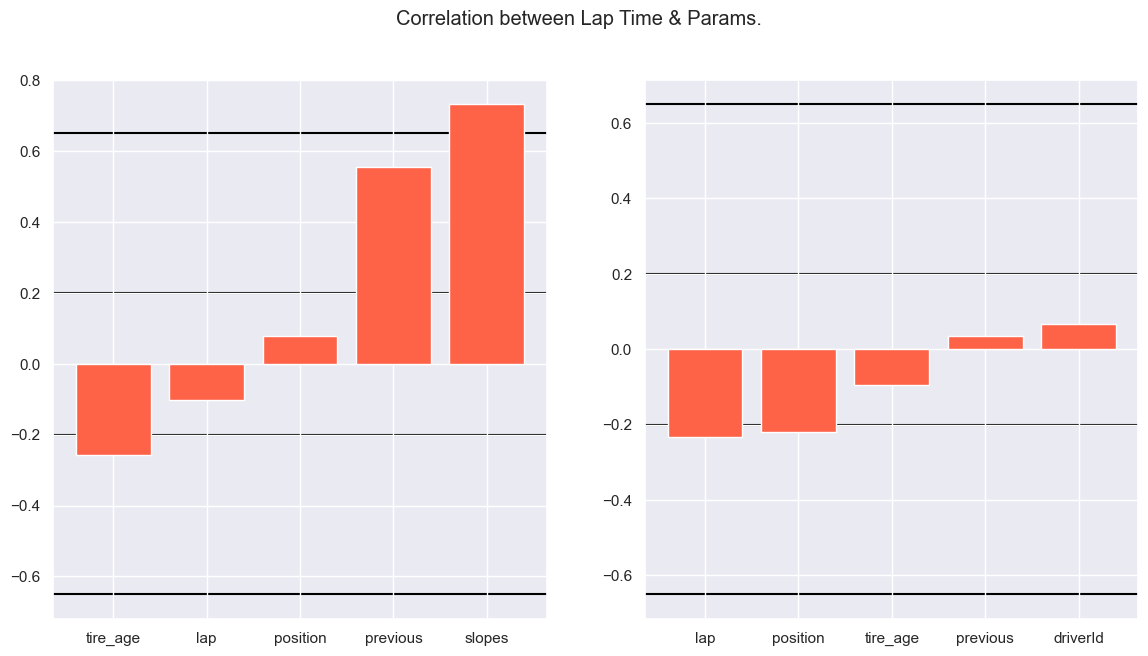

In [11]:
corr_milli = r_data.drop(columns=['time', 'cum_milli', 'driverId', 'delta']).corr()['milliseconds'].sort_values()
corr_delta = r_data.drop(columns=['time', 'cum_milli', 'milliseconds', 'slopes']).corr()['delta'].sort_values()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

fig.suptitle('Correlation between Lap Time & Params.')
ax1.axhline(y=-0.65, color='black', zorder=0), ax1.axhline(y=-0.2, color='black', zorder=0)
ax1.axhline(y=0.65, color='black', zorder=0), ax1.axhline(y=0.2, color='black', zorder=0)
ax1.bar(corr_milli.index.to_list()[:-1], corr_milli.to_list()[:-1], color='tomato')

ax2.axhline(y=-0.65, color='black', zorder=0), ax2.axhline(y=-0.2, color='black', zorder=0)
ax2.axhline(y=0.65, color='black', zorder=0), ax2.axhline(y=0.2, color='black', zorder=0)
ax2.bar(corr_delta.index.to_list()[:-1], corr_delta.to_list()[:-1], color='tomato')

plt.show()

# Bayesian Model

## Import Data

In [12]:
dim = 4
data = r_data.dropna()
inputs = data[['tire_age', 'delta', 'previous', 'slopes']].to_numpy()
outputs = data[['milliseconds']].to_numpy()

## Initialize Model

In [13]:
noise_var = 1000
prior = Prior(np.zeros(dim + 1), np.diag(np.diag(np.ones((dim + 1, dim + 1)) * 10)))
blr = BLR(prior, noise_var)
blr.update_post(inputs, outputs)

## Make Prediction

In [14]:
pred = blr.predict(np.reshape(inputs[673][:], (1, dim)))
pred_mean, pred_std = float(pred.mean()), float(pred.std())
pred_x = np.linspace(pred_mean - 5 * noise_var, pred_mean + 5 * noise_var, 1000)

## Visualize Posterior Predictive Distribution

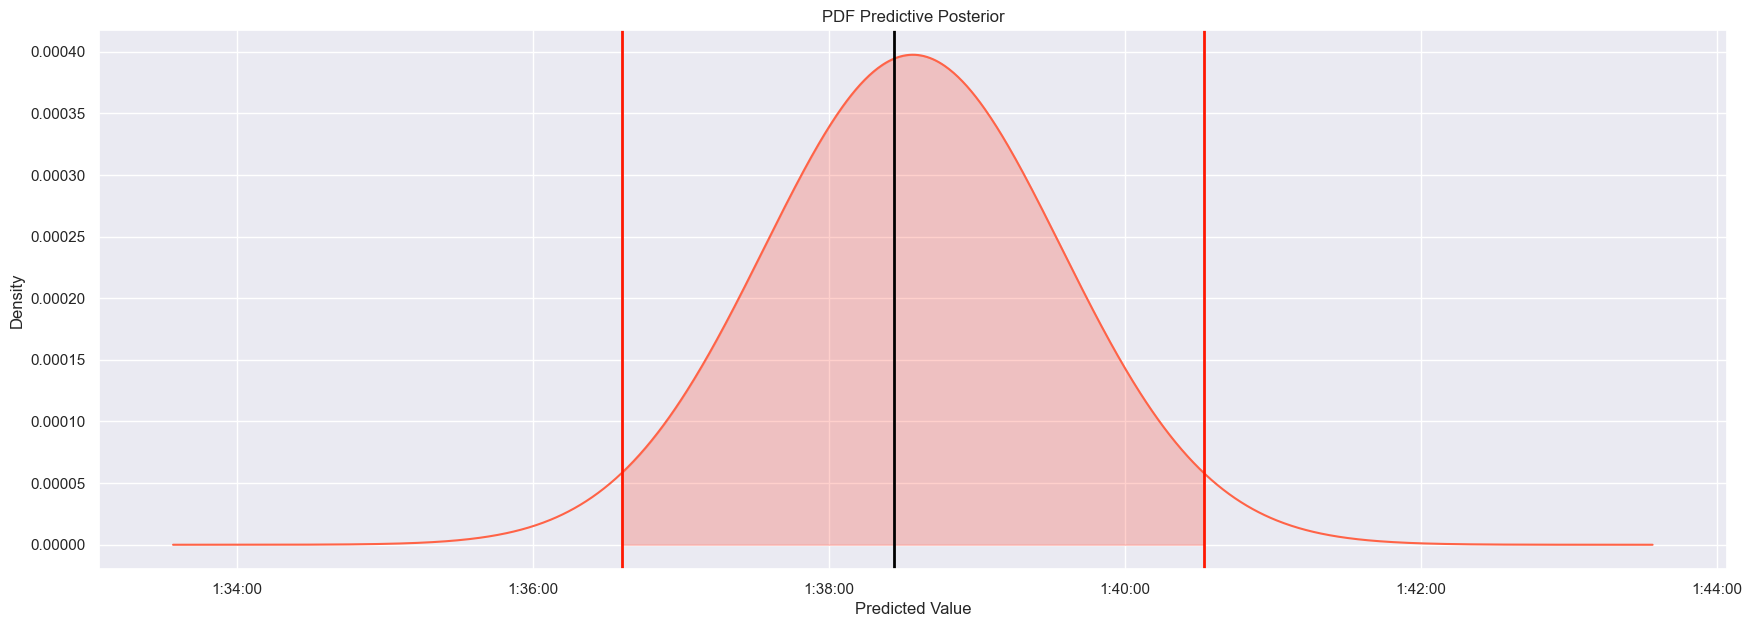

In [15]:
sns.set(rc={'figure.figsize':(21,7)})
plt.title('PDF Predictive Posterior')
plt.xlabel('Predicted Value'), plt.ylabel('Density')
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_tick))
plt.plot(pred_x, pred.pdf(pred_x).T, color='tomato')
plt.axvline(pred_mean - 1.96 * pred_std, linewidth=2, color='#ff1801'), plt.axvline(pred_mean + 1.96 * pred_std, linewidth=2,  color='#ff1801')
plt.axvline(int(outputs[673]), linewidth=2, color='#000000')
plt.fill_between(pred_x, pred.pdf(pred_x).tolist()[0], where=(pred_mean - 1.96 * pred_std < pred_x) & (pred_x < pred_mean + 1.96 * pred_std), alpha=0.2, color='#ff1801')
plt.show()

# Monte-Carlo Simulation

## Simulation Parameters

In [16]:
n_simu = 100
n_lap = r_data['lap'].max()
participants = participating(drivers, r_data, n_lap)

## Initialization of Drivers

In [17]:
def create_drivers(r_data, raceId, n_lap, lap):
    _drivers = []
    for i in r_data['driverId'].unique().tolist():
        driver_data = r_data[r_data['driverId'] == i]
        pts_dr = list(pit_stops[(pit_stops['raceId'] == raceId) & (pit_stops['driverId'] == i)]['lap'].values)
        if len(driver_data) == n_lap:
            pilot = Pilot(i, drivers[drivers['driverId'] == i]['code'].tolist()[0], driver_data['previous'].iloc[1:lap + 1].tolist(), pts_dr) #lap+1
            _drivers.append(pilot)
    _drivers.sort(key=lambda x: x.cumulative[-1])
    return _drivers

## Simulation

In [18]:
race_sim = []
for lap in range(5, n_lap + 1):
    res = []
    for i in range(n_simu):
        _drivers = create_drivers(r_data, raceId, n_lap, lap)
        for n in range(lap, n_lap + 1):
            for j, d in enumerate(_drivers):
                d.update(n, _drivers[j]) if j - 1 >= 0 else d.update(n, None)
                input = np.array([[d.tire_age, d.delta, d.previous[-2], d.pace]])
                pred = blr.predict(input)
                d.previous.append(int(pred.rvs(1)))
            _drivers.sort(key=lambda x: x.cumulative[-1])
        res.append([i.code for i in _drivers])
    win_prob = np.array([prob_position(res, dr) for dr in participants])
    race_sim.append(win_prob)

## Visualize Final Position Probabilities

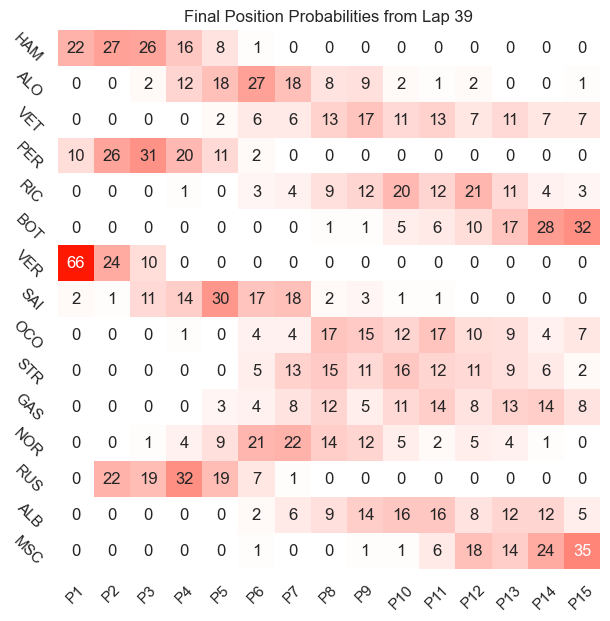

In [27]:
lap = 39
sns.set(rc={'figure.figsize':(7, 7)})
sns.heatmap(race_sim[lap], xticklabels=[f'P{i + 1}' for i in range(len(race_sim[0]))], yticklabels=participants, annot=True, cbar=False, cmap=red).set_title(f'Final Position Probabilities from Lap {lap}')
plt.xticks(rotation=45), plt.yticks(rotation=-45)
plt.show()

## Generate Win Probability Array

In [20]:
win_cum = [np.cumsum(i.T[:][0]/i.T[:][0].sum(axis=0) * 100).astype(int).tolist() for i in race_sim]
lap = [i for i in range(5, n_lap + 1) for _ in range(len(participants))]
drivers = participants * (n_lap - 4)

## Visualize Win Probability

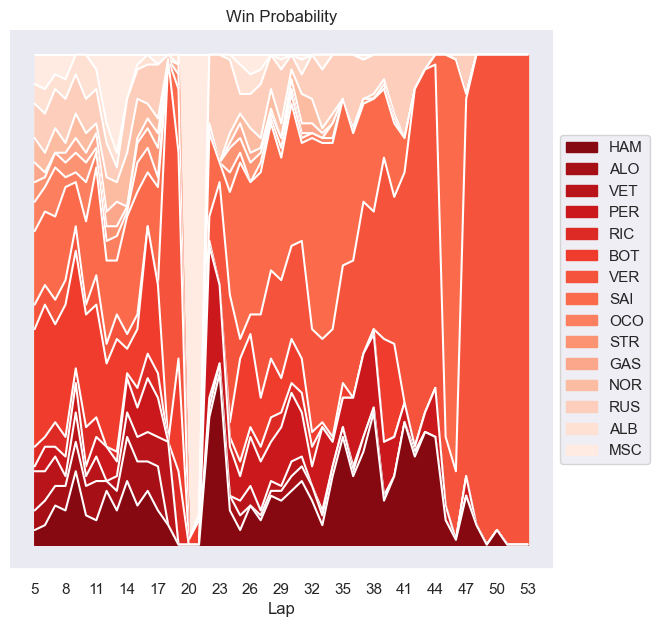

In [21]:
laped = [i for i in range(5, n_lap + 1)]

sns.set(rc={'figure.figsize':(7, 7)})
for d in range(len(participants)):
    probs = [win_cum[l][d] for l in range(n_lap - 4)]
    plt.fill_between(laped, probs, label=participants[d], color=reds[d], zorder=len(participants) - d)
    plt.plot(laped, probs, color='white', zorder=len(participants) - d)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(axis='x')
plt.title('Win Probability')
plt.xlabel('Lap')
plt.yticks([]), plt.xticks(np.arange(min(laped), max(laped)+1, 3.0))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.show()